In [1]:
import glob
import time
import numpy as np
import pandas as pd
from contextlib import closing
from multiprocessing import Pool
import multiprocessing
from functools import partial
import os
import random

In [2]:
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [3]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,roc_curve, accuracy_score
from sklearn.metrics import auc
#import lightgbm as lgb

In [4]:
all_data = pd.read_csv('data.csv')

In [5]:
all_data.head(10)

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
6,O=S(=O)(Cl)c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,0.0,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0
8,OC[C@H](O)[C@@H](O)[C@H](O)CO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
9,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN


In [6]:
all_data.describe()

,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
count,7439.000000,6902.000000,6691.000000,5940.000000,6316.000000,7112.000000,6583.000000,5935.000000,7232.000000,6594.000000,5920.000000,6909.000000
mean,0.041672,0.034483,0.117322,0.051684,0.126346,0.050056,0.028710,0.161921,0.036919,0.057476,0.158108,0.062382
std,0.199853,0.182479,0.321827,0.221406,0.332265,0.218076,0.167004,0.368409,0.188577,0.232768,0.364873,0.241866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
len(all_data)

8014

In [8]:
np.sum(all_data==1,axis=0)

smiles        0
target1     310
target2     238
target3     785
target4     307
target5     798
target6     356
target7     189
target8     961
target9     267
target10    379
target11    936
target12    431
dtype: int64

In [9]:
fdef = 'MinimalFeatures.fdef'

In [10]:
def get_descriptors(smile,name):
    mol = Chem.MolFromSmiles(smile)
    arg = np.zeros(len(name),)
    for i,keys in enumerate(name):
        try:
            item = getattr(Descriptors,keys)
            arg[i] = item(mol)
        except:
            print(keys)
    return arg

In [11]:
def maccs_fingp(smile):
    try:
        temp = np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smile)))
    except:
        print(smile)
    return temp

In [12]:
def pharma_fingp(smile):
    featFactory = ChemicalFeatures.BuildFeatureFactory(fdef)
    sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3,trianglePruneBins=False)
    sigFactory.SetBins([(0,2),(2,5),(5,8)])
    sigFactory.Init()
    #sigFactory.GetSigSize()
    try:
        mol = Chem.MolFromSmiles(smile)
        fp_p = Generate.Gen2DFingerprint(mol,sigFactory)
    except:
        print(smile)
    return fp_p

In [13]:
def morgan_fingp(smile,nbits,radius):
    arg = np.zeros((1,))
    try:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile),radius,nBits=nbits),arg)
    except:
        print(smile)
    return arg

In [14]:
# Got it from https://www.kaggle.com/corochann/visualize-molecules-with-rdkit
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

# Target 1 prediction

All the other targets can be predicted in a similar manner. I started with visuzlizing the toxic molecules, found many aliphatic rings and bigger molecules. I first tried fingerprints, morgan and maccs, which didn't work well that well. This can be due to the fact that fingerprints try to capture overall structure of the molecule but not specific sub structures. Based on this hypothesis i tried various descriptors from RdKit, and it seems it gave better accuracy, ROC-AUC, precision and recall. Then i took a look at the importance of different descitors, and as visualized intitally the most important descriptor were number of aromatic rings, molecular weight and water octanol partition coefficient.

In [15]:
#Getting target 1 data
target_data = all_data[['smiles','target1']]

In [16]:
target_data.head(10)

,smiles,target1
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0
6,O=S(=O)(Cl)c1ccccc1,0.0
7,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,0.0
8,OC[C@H](O)[C@@H](O)[C@H](O)CO,0.0
9,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],NaN


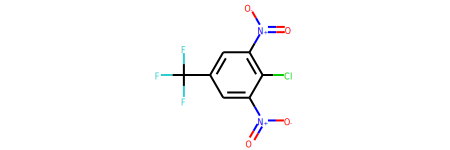

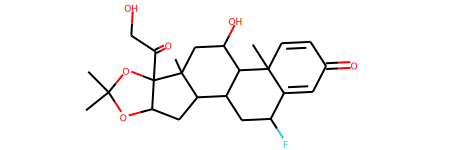

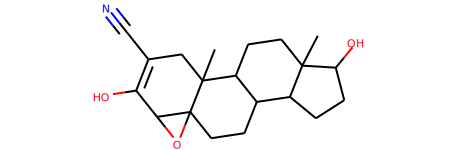

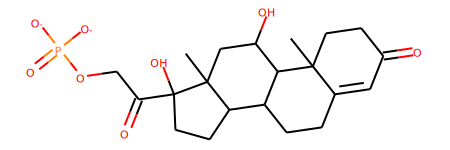

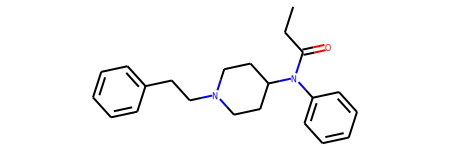

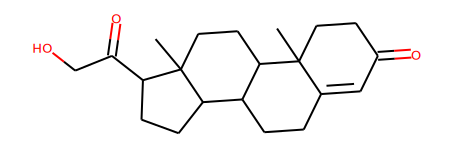

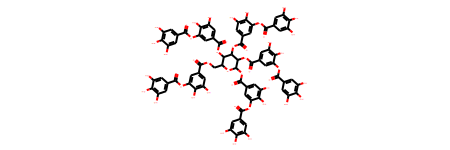

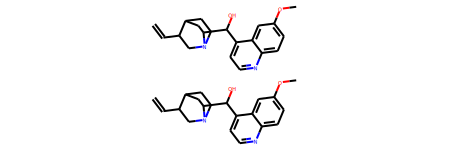

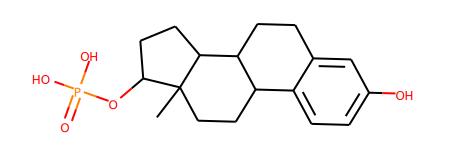

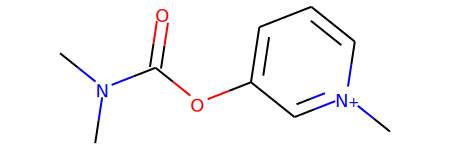

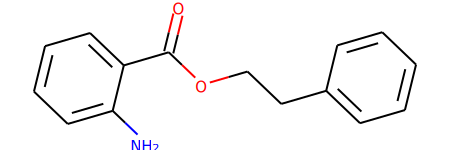

In [17]:
#Got it from https://www.kaggle.com/corochann/visualize-molecules-with-rdkit
#mols = []
#Toxic compounds
for i,smile in enumerate(target_data[target_data.target1==1].smiles):
    mol = Chem.MolFromSmiles(smile)
    #mols.append(mol)
    display(render_svg(moltosvg(mol)))
    if i>9:
        break
#img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250, 250),legends=None, useSVG=True)

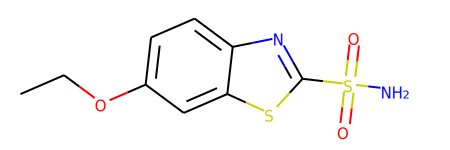

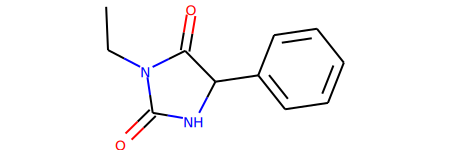

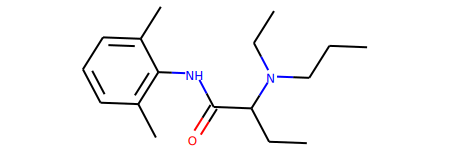

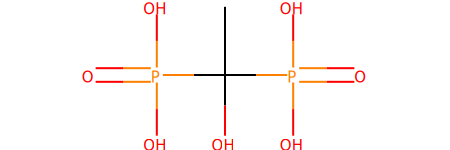

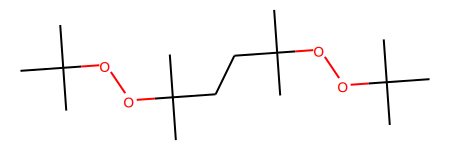

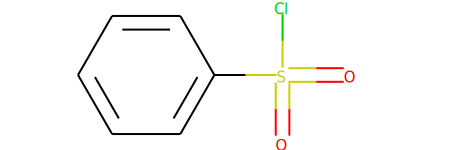

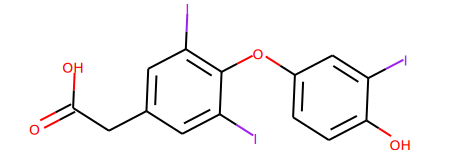

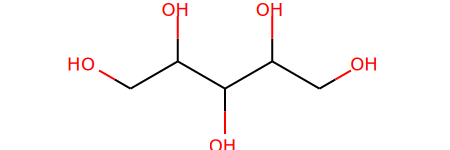

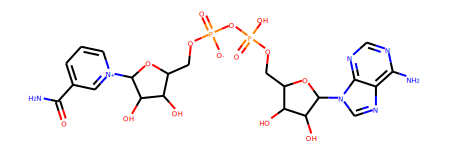

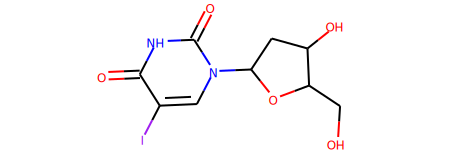

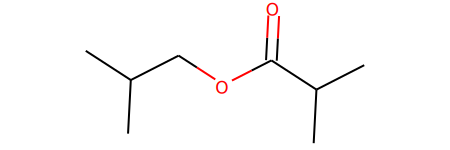

In [286]:
#Got it from https://www.kaggle.com/corochann/visualize-molecules-with-rdkit
#mols = []
#NonToxic compounds
for i,smile in enumerate(target_data[target_data.target1==0].smiles):
    mol = Chem.MolFromSmiles(smile)
    #mols.append(mol)
    display(render_svg(moltosvg(mol)))
    if i>9:
        break
#img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250, 250),legends=None, useSVG=True)

In [18]:
#getting rid on Na's in future I can try to have a different class for Na's or try to substitute it with 
#majority class or try model the missing value as latent variable
target_data = target_data[~target_data.target1.isna()]

In [19]:
target_data.shape

(7439, 2)

In [20]:
#Getting positive molecules
pos_mol = target_data[target_data.target1==1]

In [21]:
pos_mol.shape

(310, 2)

In [22]:
pos_ct = len(pos_mol)

In [23]:
#Getting negative molecules
neg_mol = target_data[target_data.target1==0]

In [24]:
neg_mol.shape

(7129, 2)

In [25]:
neg_ct = len(neg_mol)

In [287]:
#Fraction of train-validation split
fraction_sep = 0.2

In [288]:
# Number of pos training and validation. Number of neg training and validation
tr_pos = int(pos_ct*(1-fraction_sep))
tr_ng = int(neg_ct*(1-fraction_sep))
vl_pos = pos_ct - tr_pos
vl_ng = neg_ct - tr_ng

In [289]:
print(tr_pos,tr_ng,vl_pos,vl_ng)

248 5703 62 1426


In [290]:
#Getting the index for validation and test set for positive nad negative (I didnt use train-test split from sklearn)
pos_idx = np.arange(pos_ct)
random.shuffle(pos_idx)
neg_idx = np.arange(neg_ct)
random.shuffle(neg_idx)

In [291]:
# Getting validation set
validation_pos = pos_mol.iloc[pos_idx[:vl_pos]]
validation_neg = neg_mol.iloc[neg_idx[:vl_ng]]

In [292]:
full_validation = pd.concat([validation_pos,validation_neg])
full_validation = shuffle(full_validation)

In [293]:
#oversampling the toxic class and undersampling the non toxic class
overampling_pos_val = tr_ng
undersampling_val_neg = tr_ng

In [294]:
training_pos = pos_mol.iloc[random.choices(pos_idx[vl_pos:],k=overampling_pos_val)]
training_neg = neg_mol.iloc[random.choices(neg_idx[vl_ng:],k=undersampling_val_neg)]

In [295]:
print(training_pos.shape,training_neg.shape)

(5703, 13) (5703, 13)


In [296]:
full_training = pd.concat([training_pos,training_neg])

In [297]:
full_training = shuffle(full_training)

In [298]:
full_training.head(10)

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
1283,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,1.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
4029,ClCCOCCCl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7453,N#C[Au-]C#N,0.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN
2554,BrC(Br)Br,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481,CC(=O)N1C[C@H](O)C[C@H]1C(=O)O,1.0,1.0,NaN,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2034,N[C@@H](CS)C(=O)O,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
7202,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,1.0
4703,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,0.0,NaN,1.0,NaN,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3040,N#CCC#N,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,1.0,NaN,NaN
2820,CCCCCCCCCCCO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [345]:
#Using multiprocessing to get morgan fingerprint with radius 2 and 1024 bits
smile_train,y_train = list(full_training.smiles.values),full_training.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_train = pool.map(partial(morgan_fingp,nbits=1024,radius=2),smile_train)
smile_valid,y_valid = list(full_validation.smiles.values),full_validation.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_valid = pool.map(partial(morgan_fingp,nbits=1024,radius=2),smile_valid)
x_train = np.array(x_train,dtype='float32')
x_valid = np.array(x_valid,dtype='float32')

RDKit WARNING: [15:39:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:39:26] WARNING: not removing hydrogen atom without neighbors


In [ ]:
#Using multiprocessing to get maccs fingerprints
smile_train,y_train = list(full_training.smiles.values),full_training.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_train = pool.map(maccs_fingp,smile_train)
smile_valid,y_valid = list(full_validation.smiles.values),full_validation.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_valid = pool.map(maccs_fingp,smile_valid)

In [368]:
#Get all the 2D descriptor names available in RdKit with only integral values (to keep it easier to understand)
mol = Chem.MolFromSmiles('CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C')
name = []
for fun in dir(Descriptors):
    item = getattr(Descriptors,fun)
    try:
        if callable(item):
            temp = item(mol)
            try:
                #if type(temp)==int:
                temp = float(temp)
                #    name.append(fun)
                name.append(fun)
            except:
                pass
    except:
        pass

7 items had no tests:
    __main__
    __main__.get_descriptors
    __main__.maccs_fingp
    __main__.moltosvg
    __main__.morgan_fingp
    __main__.pharma_fingp
    __main__.render_svg
0 tests in 7 items.
0 passed and 0 failed.
Test passed.


In [369]:
len(name)

201

In [370]:
#name = ['NumAliphaticCarbocycles','NumAliphaticRings','fr_alkyl_halide']

In [371]:
#Using multiprocessing to get all the 2D descriptors
smile_train,y_train = list(full_training.smiles.values),full_training.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_train_per = pool.map(partial(get_descriptors,name=name),smile_train)
smile_valid,y_valid = list(full_validation.smiles.values),full_validation.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_valid_per = pool.map(partial(get_descriptors,name=name),smile_valid)

RDKit WARNING: [15:45:22] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:45:22] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:45:31] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:45:31] WARNING: not removing hydrogen atom without neighbors


In [372]:
x_train = np.array(x_train_per,dtype='float32')
x_valid = np.array(x_valid_per,dtype='float32')

In [373]:
print(x_train.shape)

(11406, 201)


In [374]:
#Getting rid of all the low variance columns
idx_to_take = list(np.where(np.std(x_train,axis=0)>0.1)[0])

/home/vagrawal/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/vagrawal/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [375]:
len(idx_to_take)

170

In [376]:
#Checking for inf or nan in any column
inf_index = np.where(np.sum(x_train,axis=0)==np.inf)[0]
nan_index = np.where(np.sum(x_train,axis=0)==np.nan)[0]
idx_to_take_temp = idx_to_take
for idx in idx_to_take_temp:
    if idx in inf_index or idx in nan_index:
        idx_to_take.remove(idx)

In [377]:
nan_index

array([], dtype=int64)

In [378]:
inf_index

array([33])

In [379]:
len(idx_to_take)

170

In [380]:
# All the descriptors with low variance
list(np.array(name)[np.where(np.std(x_train,axis=0)<=0.1)[0]])

/home/vagrawal/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 '_isCallable',
 'fr_HOCCN',
 'fr_N_O',
 'fr_SH',
 'fr_alkyl_carbamate',
 'fr_amidine',
 'fr_azide',
 'fr_barbitur',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_hdrzone',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_oxazole',
 'fr_oxime',
 'fr_prisulfonamd',
 'fr_sulfone',
 'fr_tetrazole',
 'fr_thiocyan']

In [381]:
#Only taking descriptors with high variance
x_train = x_train[:,idx_to_take]
x_valid = x_valid[:,idx_to_take]

In [382]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(11406, 170) (11406,) (1488, 170) (1488,)


In [383]:
#training radom forest with low depth to preven overfitting and 500 trees and rest all parameters as default
rf = RandomForestClassifier(n_estimators = 1000,max_depth=4,class_weight={0:1,1:1},n_jobs=-1)

In [384]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [385]:
#Feature importance list
sorted_list = rf.feature_importances_.argsort()[::-1]

In [386]:
#Sorted feature importance list
rf.feature_importances_[sorted_list][:5]

array([0.0720122 , 0.07089559, 0.05604242, 0.05422602, 0.0501082 ])

In [387]:
#Printing descriptors and their importance
for na,val in enumerate(zip(list(np.array(name)[sorted_list]),rf.feature_importances_[sorted_list])):
    print(str(na),str(val))

0 ('MolLogP', 0.07201219788689858)
1 ('fr_Ndealkylation1', 0.07089559273376696)
2 ('MolWt', 0.056042420060165965)
3 ('NumAromaticRings', 0.05422601616863088)
4 ('Chi4n', 0.05010820259064401)
5 ('PEOE_VSA9', 0.046851005788599666)
6 ('Chi3n', 0.04211473362890281)
7 ('SMR_VSA9', 0.03699435630801226)
8 ('NumHDonors', 0.03181467363573802)
9 ('PEOE_VSA4', 0.03101649802370162)
10 ('BertzCT', 0.027544509046693665)
11 ('Chi4v', 0.02742448813860575)
12 ('Chi3v', 0.024523597480548158)
13 ('PEOE_VSA14', 0.02109815729591032)
14 ('Chi2n', 0.017614378813183316)
15 ('HallKierAlpha', 0.016522507144231927)
16 ('BalabanJ', 0.014559656807536882)
17 ('fr_aniline', 0.014065218424737763)
18 ('RingCount', 0.01327214447968666)
19 ('Chi1n', 0.011832996798689004)
20 ('MinAbsEStateIndex', 0.011615197876045973)
21 ('Kappa3', 0.010368318859853419)
22 ('Chi2v', 0.010154301740745924)
23 ('FpDensityMorgan3', 0.009821060516314517)
24 ('MaxAbsEStateIndex', 0.009710492535804818)
25 ('Chi1v', 0.00964696465565739)
26 ('Chi

In [388]:
#Training stats (to measure overfitting or underfitting)
prediction_train = rf.predict_proba(x_train)[:,1]

In [389]:
#Prescision recall curve since AUC and accuarcy are not best way to measure performance on a unbalanced dataset
precision_tr, recall_tr, thresholds_tr = precision_recall_curve(y_train,prediction_train)

In [390]:
#ROC and calculating precsion are 80% recall i.e. 80% Toxic molecules are correctly labelled (can be changed based on
# requirement whether they want higher precision or recall)
fpr_tr, tpr_tr, thresh_tr = roc_curve(y_train, prediction_train)
auc_tr = auc(fpr_tr,tpr_tr)
pr_tr = precision_tr[np.where(recall_tr>0.8)[0][-1]]

In [391]:
print(auc_tr,pr_tr)

0.9182033143373295 0.9235900545785325


In [392]:
#Validation stats for all the same
prediction_valid = rf.predict_proba(x_valid)[:,1]

In [393]:
precision_vl, recall_vl, thresholds_vl = precision_recall_curve(y_valid,prediction_valid)

In [394]:
fpr_vl, tpr_vl, thresh_vl = roc_curve(y_valid, prediction_valid)
auc_vl = auc(fpr_vl,tpr_vl)
pr_vl = precision_vl[np.where(recall_vl>=0.8)[0][-1]]

In [395]:
thresholds_vl[np.where(recall_vl>=0.8)[0][-1]]

0.3330717109253757

In [396]:
rf.score(x_valid,y_valid)

0.9543010752688172

In [397]:
#Accuracy of positive class/toxic class is 55% which is lot higher than the random chance (4%) [This is most important]
rf.score(x_valid[y_valid==1],y_valid[y_valid==1])

0.532258064516129

In [398]:
#Accuracy of negative class/non toxic class is 97% which is higher than the random chance (96%)
rf.score(x_valid[y_valid==0],y_valid[y_valid==0])

0.9726507713884993

In [399]:
#Random best accuaracy is 96%
np.sum(y_valid==0)/len(y_valid)

0.9583333333333334

In [400]:
print(auc_vl,pr_vl)

0.8301814233361987 0.08756567425569177


In [401]:
#Random precision if we label everything is toxic and hence we get an enrichment of about 2x
np.sum(y_valid)/len(y_valid)

0.041666666666666664

In [402]:
#Top n enrichment scores
top_n_enrichment = []
a = np.argsort(prediction_valid)[::-1]
scores = []
for fold in [10,50,100]:
    y_new = y_valid[a[:fold]]
    y_new_pred = prediction_valid[a[:fold]]
    scores.append([fold,np.sum(y_new)/(np.sum(y_valid)/len(y_valid)*fold)])

In [403]:
scores

[[10, 21.6], [50, 14.400000000000002], [100, 8.160000000000002]]

# Predicting toxicity for target 1 based on other targets

First I visualized if there is any correlation between different target toxicity, seeing that there is decent correlation between targets i tried to predict the toxicity of a target based on the other targets as features. This can be also done for any other target using the same approach

In [404]:
#corellation metrix for all targets
all_data.drop(columns='smiles').corr()

,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
target1,1.000000,0.565337,0.017768,0.029735,0.230872,0.197479,-0.013511,0.068428,0.058266,-0.024424,0.021329,0.021040
target2,0.565337,1.000000,0.008609,0.124251,0.226740,0.318316,0.220428,0.140357,0.190156,0.136885,0.103005,0.239362
target3,0.017768,0.008609,1.000000,0.198933,0.225118,0.101407,0.047586,0.301760,0.271949,0.114914,0.351367,0.170791
target4,0.029735,0.124251,0.198933,1.000000,0.089354,0.136735,0.080045,0.283260,0.133027,0.206848,0.337581,0.256867
target5,0.230872,0.226740,0.225118,0.089354,1.000000,0.542598,0.028606,0.186532,0.257040,0.071498,0.260495,0.131158
target6,0.197479,0.318316,0.101407,0.136735,0.542598,1.000000,0.147029,0.211954,0.226042,0.190465,0.272279,0.221381
target7,-0.013511,0.220428,0.047586,0.080045,0.028606,0.147029,1.000000,0.204099,0.243373,0.288994,0.184312,0.332107
target8,0.068428,0.140357,0.301760,0.283260,0.186532,0.211954,0.204099,1.000000,0.255896,0.275985,0.439680,0.347036
target9,0.058266,0.190156,0.271949,0.133027,0.257040,0.226042,0.243373,0.255896,1.000000,0.182150,0.213882,0.327354
target10,-0.024424,0.136885,0.114914,0.206848,0.071498,0.190465,0.288994,0.275985,0.182150,1.000000,0.275743,0.378728


In [405]:
target_data = all_data[~all_data.target1.isna()]

In [406]:
target_data.shape

(7439, 13)

In [407]:
#Getting positive molecules
pos_mol = target_data[target_data.target1==1]

In [408]:
pos_mol.shape

(310, 13)

In [409]:
pos_ct = len(pos_mol)

In [410]:
#Getting negative molecules
neg_mol = target_data[target_data.target1==0]

In [411]:
neg_mol.shape

(7129, 13)

In [452]:
neg_ct = len(neg_mol)

In [453]:
#Fraction of train-validation split
fraction_sep = 0.2

In [454]:
# Number of pos training and validation. Number of neg training and validation
tr_pos = int(pos_ct*(1-fraction_sep))
tr_ng = int(neg_ct*(1-fraction_sep))
vl_pos = pos_ct - tr_pos
vl_ng = neg_ct - tr_ng

In [455]:
print(tr_pos,tr_ng,vl_pos,vl_ng)

248 5703 62 1426


In [456]:
#Getting the index for validation and test set for positive nad negative (I didnt use train-test split from sklearn)
pos_idx = np.arange(pos_ct)
random.shuffle(pos_idx)
neg_idx = np.arange(neg_ct)
random.shuffle(neg_idx)

In [457]:
# Getting validation set
validation_pos = pos_mol.iloc[pos_idx[:vl_pos]]
validation_neg = neg_mol.iloc[neg_idx[:vl_ng]]

In [458]:
full_validation = pd.concat([validation_pos,validation_neg])
full_validation = shuffle(full_validation)

In [459]:
#oversampling the toxic class and undersampling the non toxic class
overampling_pos_val = tr_ng
undersampling_val_neg = tr_ng

In [460]:
training_pos = pos_mol.iloc[random.choices(pos_idx[vl_pos:],k=overampling_pos_val)]
training_neg = neg_mol.iloc[random.choices(neg_idx[vl_ng:],k=undersampling_val_neg)]

In [461]:
print(training_pos.shape,training_neg.shape)

(5703, 13) (5703, 13)


In [462]:
full_training = pd.concat([training_pos,training_neg])

In [463]:
full_training = shuffle(full_training)

In [464]:
full_training.head(10)

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
5620,O=P([O-])(O)C(Sc1ccc(Cl)cc1)P(=O)([O-])O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4119,CC(=O)OCC(CCn1cnc2cnc(N)nc21)COC(C)=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6918,CCC[N+]1(C)CCCC1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481,CC(=O)N1C[C@H](O)C[C@H]1C(=O)O,1.0,1.0,NaN,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2222,O=C1CC2CC1C1CCCC21,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2537,CCCC(=O)Nc1c(I)cc(I)c(CC(CC)C(=O)[O-])c1I,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
676,C[N+](C)(C)CC(=O)[O-],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6821,C=C(C)C1CC=C(C)CC1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7433,CC(=O)OCC(=O)[C@@]1(O)[C@H](C)C[C@H]2[C@@H]3C[...,1.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
1091,Cc1cc(Cc2cc(C)cc(C(C)(C)C)c2O)c(O)c(C(C)(C)C)c1,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN


In [465]:
x_train,y_train = full_training.drop(columns=['smiles','target1']).values,full_training.target1.values.reshape(-1,)

In [466]:
x_valid,y_valid = full_validation.drop(columns=['smiles','target1']).values,full_validation.target1.values.reshape(-1,)

In [467]:
#Making Na a feature
x_train[np.isnan(x_train)] = 3
x_valid[np.isnan(x_valid)] = 3

In [468]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(11406, 11) (11406,) (1488, 11) (1488,)


In [469]:
#training radom forest with low depth to preven overfitting and 500 trees and rest all parameters as default
rf = RandomForestClassifier(n_estimators = 1000,max_depth=3,class_weight={0:1,1:1},n_jobs=-1)

In [470]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [471]:
name = full_training.drop(columns=['smiles','target1']).columns

In [472]:
name

Index(['target2', 'target3', 'target4', 'target5', 'target6', 'target7',
       'target8', 'target9', 'target10', 'target11', 'target12'],
      dtype='object')

In [473]:
#Feature importance list
sorted_list = rf.feature_importances_.argsort()[::-1]

In [474]:
#Sorted feature importance list
rf.feature_importances_[sorted_list][:5]

array([0.44052117, 0.18811872, 0.13577674, 0.07794881, 0.0419454 ])

In [475]:
#Printing descriptors and their importance
for na,val in enumerate(zip(list(np.array(name)[sorted_list]),rf.feature_importances_[sorted_list])):
    print(str(na),str(val))

0 ('target2', 0.4405211671705772)
1 ('target4', 0.188118717742592)
2 ('target5', 0.13577674163058615)
3 ('target6', 0.07794881140129098)
4 ('target12', 0.04194540399852443)
5 ('target8', 0.033267948219549884)
6 ('target7', 0.030080609218393433)
7 ('target9', 0.019830433369541055)
8 ('target10', 0.017338259457135626)
9 ('target11', 0.010209233976563831)
10 ('target3', 0.004962673815245421)


In [476]:
#Training stats (to measure overfitting or underfitting)
prediction_train = rf.predict_proba(x_train)[:,1]

In [477]:
#Prescision recall curve since AUC and accuarcy are not best way to measure performance on a unbalanced dataset
precision_tr, recall_tr, thresholds_tr = precision_recall_curve(y_train,prediction_train)

In [478]:
#ROC and calculating precsion are 80% recall i.e. 80% Toxic molecules are correctly labelled (can be changed based on
# requirement whether they want higher precision or recall)
fpr_tr, tpr_tr, thresh_tr = roc_curve(y_train, prediction_train)
auc_tr = auc(fpr_tr,tpr_tr)
pr_tr = precision_tr[np.where(recall_tr>0.8)[0][-1]]

In [479]:
print(auc_tr,pr_tr)

0.8862991564222207 0.8361818181818181


In [480]:
#Validation stats for all the same
prediction_valid = rf.predict_proba(x_valid)[:,1]

In [481]:
precision_vl, recall_vl, thresholds_vl = precision_recall_curve(y_valid,prediction_valid)

In [482]:
fpr_vl, tpr_vl, thresh_vl = roc_curve(y_valid, prediction_valid)
auc_vl = auc(fpr_vl,tpr_vl)
pr_vl = precision_vl[np.where(recall_vl>0.8)[0][-1]]

In [483]:
rf.score(x_valid,y_valid)

0.8259408602150538

In [484]:
#Accuracy of positive class/toxic class is 55% which is lot higher than the random chance (4%) [This is most important]
rf.score(x_valid[y_valid==1],y_valid[y_valid==1])

0.7419354838709677

In [485]:
#Accuracy of negative class/non toxic class is 97% which is higher than the random chance (96%)
rf.score(x_valid[y_valid==0],y_valid[y_valid==0])

0.8295932678821879

In [486]:
#Random best accuaracy is 96%
np.sum(y_valid==0)/len(y_valid)

0.9583333333333334

In [487]:
print(auc_vl,pr_vl)

0.8642548522824957 0.1282051282051282


In [488]:
#Random precision if we label everything is toxic and hence we get an enrichment of about 5x
np.sum(y_valid)/len(y_valid)

0.041666666666666664

In [489]:
top_n_enrichment = []
a = np.argsort(prediction_valid)[::-1]
scores = []
for fold in [10,50,100]:
    y_new = y_valid[a[:fold]]
    y_new_pred = prediction_valid[a[:fold]]
    scores.append([fold,np.sum(y_new)/(np.sum(y_valid)/len(y_valid)*fold)])

In [490]:
scores

[[10, 21.6], [50, 13.440000000000001], [100, 8.4]]

# Combining the above two approaches

Trained two models, one based on fingerprint and the second based on other targets. Combined the prediction from both the models (form of ensambling) to get more robust results.

In [491]:
target_data = all_data[~all_data.target1.isna()]

In [492]:
target_data.shape

(7439, 13)

In [493]:
#Getting positive molecules
pos_mol = target_data[target_data.target1==1]

In [494]:
pos_mol.shape

(310, 13)

In [495]:
pos_ct = len(pos_mol)

In [496]:
#Getting negative molecules
neg_mol = target_data[target_data.target1==0]

In [497]:
neg_mol.shape

(7129, 13)

In [498]:
neg_ct = len(neg_mol)

In [499]:
#Fraction of train-validation split
fraction_sep = 0.2

In [500]:
# Number of pos training and validation. Number of neg training and validation
tr_pos = int(pos_ct*(1-fraction_sep))
tr_ng = int(neg_ct*(1-fraction_sep))
vl_pos = pos_ct - tr_pos
vl_ng = neg_ct - tr_ng

In [501]:
print(tr_pos,tr_ng,vl_pos,vl_ng)

248 5703 62 1426


In [502]:
#Getting the index for validation and test set for positive nad negative (I didnt use train-test split from sklearn)
pos_idx = np.arange(pos_ct)
random.shuffle(pos_idx)
neg_idx = np.arange(neg_ct)
random.shuffle(neg_idx)

In [503]:
# Getting validation set
validation_pos = pos_mol.iloc[pos_idx[:vl_pos]]
validation_neg = neg_mol.iloc[neg_idx[:vl_ng]]

In [504]:
full_validation = pd.concat([validation_pos,validation_neg])
full_validation = shuffle(full_validation)

In [505]:
#oversampling the toxic class and undersampling the non toxic class
overampling_pos_val = tr_ng
undersampling_val_neg = tr_ng

In [506]:
training_pos = pos_mol.iloc[random.choices(pos_idx[vl_pos:],k=overampling_pos_val)]
training_neg = neg_mol.iloc[random.choices(neg_idx[vl_ng:],k=undersampling_val_neg)]

In [507]:
print(training_pos.shape,training_neg.shape)

(5703, 13) (5703, 13)


In [508]:
full_training = pd.concat([training_pos,training_neg])

In [509]:
full_training = shuffle(full_training)

In [510]:
full_training.head(10)

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
2729,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,1.0,1.0,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,NaN,0.0
687,CC1CCCC1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN
3789,C[C@@H](Cc1ccccc1)N(C)C,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
6022,Nc1ccc(/N=N/c2ccc(-c3ccc(/N=N/c4c(S(=O)(=O)[O-...,0.0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0
4675,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4207,CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C=C(\C)CC/C=C(\C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
299,CCCCCCCCCCCCCCn1cc[n+](C)c1,0.0,NaN,0.0,1.0,NaN,NaN,NaN,1.0,0.0,NaN,1.0,NaN
5096,CCCCOCCOCCOC(=O)CCCCC(=O)OCCOCCOCCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6864,CO[C@H]1C[C@H](O[C@@H]2C(C)=CC[C@@H]3C[C@@H](C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0
5223,C#C[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0


In [511]:
x_train_1,y_train = full_training.drop(columns=['smiles','target1']).values,full_training.target1.values.reshape(-1,)

In [512]:
x_valid_1,y_valid = full_validation.drop(columns=['smiles','target1']).values,full_validation.target1.values.reshape(-1,)

In [513]:
x_train_1[np.isnan(x_train_1)] = 3
x_valid_1[np.isnan(x_valid_1)] = 3

In [514]:
#Get all the 2D descriptor names available in RdKit with only integral values (to keep it easier to understand)
mol = Chem.MolFromSmiles('CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C')
name = []
for fun in dir(Descriptors):
    item = getattr(Descriptors,fun)
    try:
        if callable(item):
            temp = item(mol)
            try:
                #if type(temp)==int:
                temp = float(temp)
                #    name.append(fun)
                name.append(fun)
            except:
                pass
    except:
        pass

7 items had no tests:
    __main__
    __main__.get_descriptors
    __main__.maccs_fingp
    __main__.moltosvg
    __main__.morgan_fingp
    __main__.pharma_fingp
    __main__.render_svg
0 tests in 7 items.
0 passed and 0 failed.
Test passed.


In [515]:
len(name)

201

In [516]:
#Using multiprocessing to get all the 2D descriptors
smile_train,y_train = list(full_training.smiles.values),full_training.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_train_per = pool.map(partial(get_descriptors,name=name),smile_train)
smile_valid,y_valid = list(full_validation.smiles.values),full_validation.target1.values.reshape(-1,)
with closing(Pool(24)) as pool:
    x_valid_per = pool.map(partial(get_descriptors,name=name),smile_valid)

RDKit WARNING: [16:02:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:02:47] WARNING: not removing hydrogen atom without neighbors


In [517]:
x_train_2 = np.array(x_train_per,dtype='float32')
x_valid_2 = np.array(x_valid_per,dtype='float32')

In [518]:
print(x_train_2.shape)

(11406, 201)


In [519]:
#Getting rid of all the low variance columns
idx_to_take = list(np.where(np.std(x_train_2,axis=0)>0.1)[0])

/home/vagrawal/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [520]:
len(idx_to_take)

171

In [521]:
#Checking for inf or nan in any column
inf_index = np.where(np.sum(x_train_2,axis=0)==np.inf)[0]
nan_index = np.where(np.sum(x_train_2,axis=0)==np.nan)[0]
idx_to_take_temp = idx_to_take
for idx in idx_to_take_temp:
    if idx in inf_index or idx in nan_index:
        idx_to_take.remove(idx)

In [522]:
nan_index

array([], dtype=int64)

In [523]:
inf_index

array([], dtype=int64)

In [524]:
len(idx_to_take)

171

In [525]:
# All the descriptors with low variance
list(np.array(name)[np.where(np.std(x_train_2,axis=0)<=0.1)[0]])

/home/vagrawal/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 '_isCallable',
 'fr_HOCCN',
 'fr_SH',
 'fr_alkyl_carbamate',
 'fr_amidine',
 'fr_azide',
 'fr_barbitur',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_furan',
 'fr_hdrzone',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_oxazole',
 'fr_prisulfonamd',
 'fr_sulfone',
 'fr_tetrazole',
 'fr_thiocyan']

In [526]:
#Only taking descriptors with high variance
x_train_2 = x_train_2[:,idx_to_take]
x_valid_2 = x_valid_2[:,idx_to_take]

In [527]:
print(x_train_2.shape,y_train.shape,x_valid_2.shape,y_valid.shape)

(11406, 171) (11406,) (1488, 171) (1488,)


In [528]:
print(x_train_1.shape,y_train.shape,x_valid_1.shape,y_valid.shape)

(11406, 11) (11406,) (1488, 11) (1488,)


In [529]:
#training radom forest with low depth to preven overfitting and 500 trees and rest all parameters as default
rf_1 = RandomForestClassifier(n_estimators = 1000,max_depth=3,class_weight={0:1,1:1},n_jobs=-1)

In [530]:
#training radom forest with low depth to preven overfitting and 500 trees and rest all parameters as default
rf_2 = RandomForestClassifier(n_estimators = 1000,max_depth=3,class_weight={0:1,1:1},n_jobs=-1)

In [531]:
rf_1.fit(x_train_1,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [532]:
rf_2.fit(x_train_2,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [563]:
#Training stats (to measure overfitting or underfitting)
#Using a average of two prediction
prediction_train = (rf_1.predict_proba(x_train_1)[:,1]+rf_2.predict_proba(x_train_2)[:,1])/2

In [548]:
#Training stats (to measure overfitting or underfitting)
#using single prediction (Just other targets)
prediction_train = rf_1.predict_proba(x_train_1)[:,1]

In [533]:
#Training stats (to measure overfitting or underfitting)
#Using single prediction (Just molecular descriptors)
prediction_train = rf_2.predict_proba(x_train_2)[:,1]

In [564]:
#Prescision recall curve since AUC and accuarcy are not best way to measure performance on a unbalanced dataset
precision_tr, recall_tr, thresholds_tr = precision_recall_curve(y_train,prediction_train)

In [565]:
#ROC and calculating precsion are 80% recall i.e. 80% Toxic molecules are correctly labelled (can be changed based on
# requirement whether they want higher precision or recall)
fpr_tr, tpr_tr, thresh_tr = roc_curve(y_train, prediction_train)
auc_tr = auc(fpr_tr,tpr_tr)
pr_tr = precision_tr[np.where(recall_tr>0.8)[0][-1]]

In [566]:
print(auc_tr,pr_tr)

0.9057125724410392 0.8341249543295579


In [567]:
#Validation stats for all the same
#Using a average of two prediction
prediction_valid = (rf_1.predict_proba(x_valid_1)[:,1]+rf_2.predict_proba(x_valid_2)[:,1])/2

In [552]:
#Validation stats for all the same
#using single prediction (Just other targets)
prediction_valid = rf_1.predict_proba(x_valid_1)[:,1]

In [537]:
#Validation stats for all the same
#Using single prediction (Just molecular descriptors)
prediction_valid = rf_2.predict_proba(x_valid_2)[:,1]

In [568]:
precision_vl, recall_vl, thresholds_vl = precision_recall_curve(y_valid,prediction_valid)

In [569]:
fpr_vl, tpr_vl, thresh_vl = roc_curve(y_valid, prediction_valid)
auc_vl = auc(fpr_vl,tpr_vl)
pr_vl = precision_vl[np.where(recall_vl>0.8)[0][-1]]

In [570]:
#rf.score(x_valid,y_valid)
accuracy_score(y_valid,prediction_valid>0.5)

0.8978494623655914

In [571]:
#Accuracy of positive class/toxic class is 55% which is lot higher than the random chance (4%) [This is most important]
#rf.score(x_valid[y_valid==1],y_valid[y_valid==1])
accuracy_score(y_valid[y_valid==1],prediction_valid[y_valid==1]>0.5)


0.7096774193548387

In [572]:
#Accuracy of negative class/non toxic class is 97% which is higher than the random chance (96%)
#rf.score(x_valid[y_valid==0],y_valid[y_valid==0])
#accuracy_score(y_valid[y_valid==0],prediction_valid[y_valid==0]<=0.5)


In [573]:
#Random best accuaracy is 96%
np.sum(y_valid==0)/len(y_valid)

0.9583333333333334

In [574]:
print(auc_vl,pr_vl)

0.899945708727322 0.1694915254237288


In [575]:
#Random precision if we label everything is toxic and hence we get an enrichment of about 5x
np.sum(y_valid)/len(y_valid)

0.041666666666666664

In [576]:
top_n_enrichment = []
a = np.argsort(prediction_valid)[::-1]
scores = []
for fold in [10,50,100]:
    y_new = y_valid[a[:fold]]
    y_new_pred = prediction_valid[a[:fold]]
    scores.append([fold,np.sum(y_new)/(np.sum(y_valid)/len(y_valid)*fold)])

In [577]:
scores

[[10, 24.000000000000004], [50, 17.28], [100, 9.600000000000001]]

# Things to try in future

1. Use all the 12 targets together, including target as one of the feature
   - Advantage is that it can act like a regulizer since we will learn same set of weights for all the targets and hence can be more robust (parameter sharing)
2. Use cross validation to improve the accuracy and make the model more robust
3. Try to model the Na's instead of throwing away the data:
   - Using Na as a feature
   - Replacing Na with some 1/0 based on other target data or closest example in the dataset
   - Modeling Na as latent variable and using Expectation Maximization
4. Use more complex models such as RNN, CNN, DNN and graphical convolutions (including attention for visualzation).